In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('Global_Pollution_Analysis.csv')

# Display basic info
print("Initial data shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())

# Handle missing data - impute with median for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Encode categorical features (Country)
label_encoder = LabelEncoder()
df['Country_Encoded'] = label_encoder.fit_transform(df['Country'])

# Normalize pollution indices and other numerical features
scaler = StandardScaler()
pollution_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index', 
                     'Industrial_Waste (in tons)', 'CO2_Emissions (in MT)']
df[pollution_features] = scaler.fit_transform(df[pollution_features])

# Create new feature: Energy consumption per capita
df['Energy_Consumption_Per_Capita'] = df['Energy_Consumption_Per_Capita (in MWh)'] / df['Population (in millions)']

# Display cleaned data
print("\nData after preprocessing:")
print(df.head())

Initial data shape: (200, 13)

Missing values per column:
Country                                   0
Year                                      0
Air_Pollution_Index                       0
Water_Pollution_Index                     0
Soil_Pollution_Index                      0
Industrial_Waste (in tons)                0
Energy_Recovered (in GWh)                 0
CO2_Emissions (in MT)                     0
Renewable_Energy (%)                      0
Plastic_Waste_Produced (in tons)          0
Energy_Consumption_Per_Capita (in MWh)    0
Population (in millions)                  0
GDP_Per_Capita (in USD)                   0
dtype: int64

Data after preprocessing:
        Country    Year  Air_Pollution_Index  Water_Pollution_Index  \
0       Hungary  2005.0             1.376167               0.193880   
1     Singapore  2001.0            -1.403578              -1.153098   
2       Romania  2016.0            -1.330788              -0.668076   
3  Cook Islands  2018.0             1.494394  

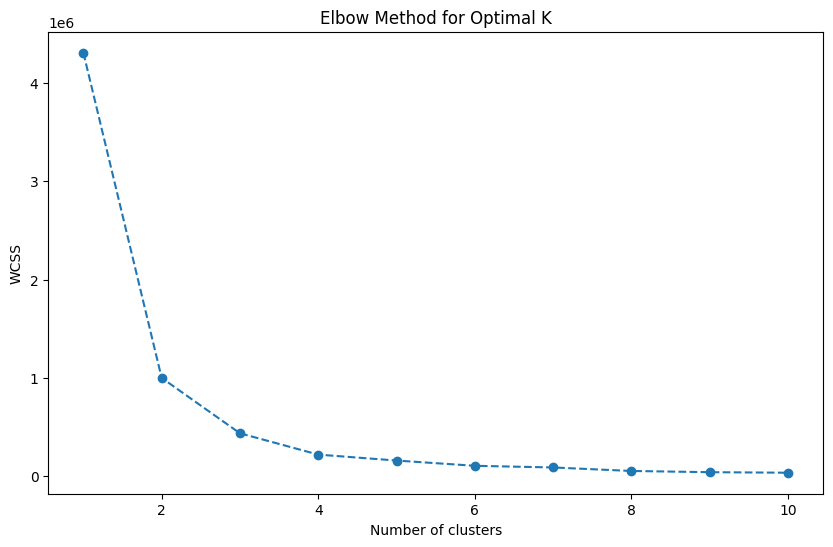

Silhouette Score for K-Means: 0.61


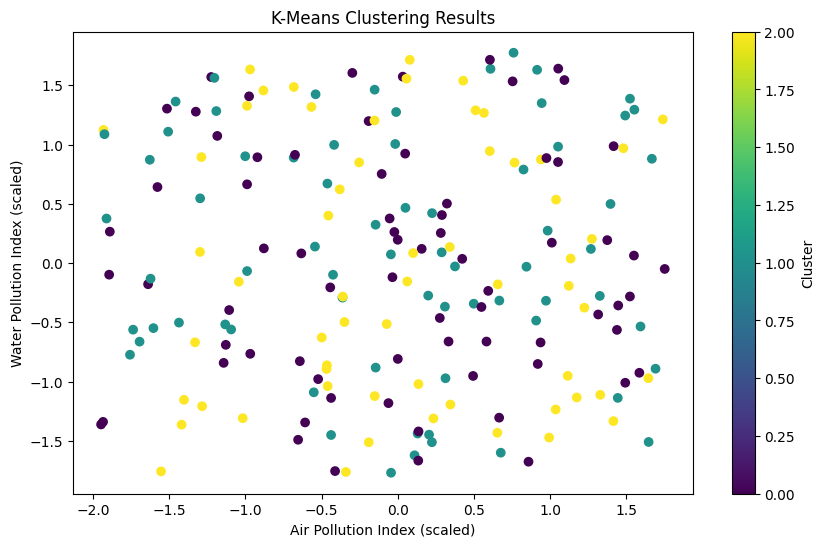


Cluster Characteristics:
                Air_Pollution_Index  Water_Pollution_Index  \
Cluster_KMeans                                               
0                         -0.007332              -0.028474   
1                         -0.021005               0.104524   
2                          0.033513              -0.087492   

                Soil_Pollution_Index  Energy_Recovered (in GWh)  \
Cluster_KMeans                                                    
0                          -0.096356                  94.079028   
1                           0.122942                 282.812754   
2                          -0.026192                 437.321525   

                Energy_Consumption_Per_Capita  
Cluster_KMeans                                 
0                                    0.293204  
1                                    0.146071  
2                                    0.238746  


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Select features for clustering
cluster_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index', 
                   'Energy_Recovered (in GWh)', 'Energy_Consumption_Per_Capita']
X_cluster = df[cluster_features]

# Determine optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_cluster)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the elbow plot, select optimal k (let's assume k=3 for this example)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_cluster)
df['Cluster_KMeans'] = clusters

# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_cluster, clusters)
print(f"Silhouette Score for K-Means: {silhouette_avg:.2f}")

# Visualize clusters (first two dimensions)
plt.figure(figsize=(10, 6))
plt.scatter(X_cluster.iloc[:, 0], X_cluster.iloc[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering Results')
plt.xlabel('Air Pollution Index (scaled)')
plt.ylabel('Water Pollution Index (scaled)')
plt.colorbar(label='Cluster')
plt.show()

# Analyze cluster characteristics
cluster_analysis = df.groupby('Cluster_KMeans')[cluster_features].mean()
print("\nCluster Characteristics:")
print(cluster_analysis)

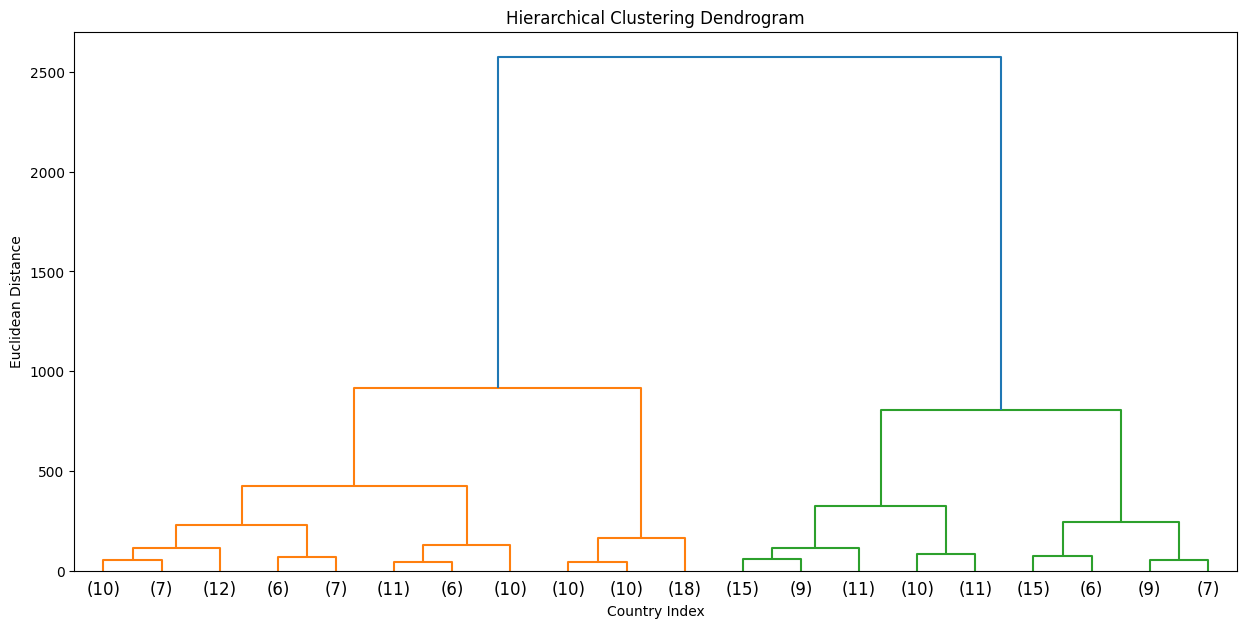

Silhouette Score for Hierarchical Clustering: 0.59

Cluster Comparison:
Hierarchical   0   1   2
K-Means                 
0             72   0   0
1             21  48   0
2              0  21  38


In [4]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd


# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(X_cluster)
df['Cluster_Hierarchical'] = hierarchical_clusters

# Plot dendrogram
linked = linkage(X_cluster, 'ward')
plt.figure(figsize=(15, 7))
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending', 
           show_leaf_counts=True,
           truncate_mode='lastp',  # Show only the last p merged clusters
           p=20)  
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Country Index')
plt.ylabel('Euclidean Distance')
plt.show()

# Evaluate clustering with silhouette score
silhouette_avg_h = silhouette_score(X_cluster, hierarchical_clusters)
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_avg_h:.2f}")

# Compare with K-Means results (ensure 'Cluster_KMeans' exists in df)
if 'Cluster_KMeans' in df.columns:
    comparison = pd.crosstab(df['Cluster_KMeans'], df['Cluster_Hierarchical'], 
                            rownames=['K-Means'], colnames=['Hierarchical'])
    print("\nCluster Comparison:")
    print(comparison)
else:
    print("\nWarning: 'Cluster_KMeans' column not found for comparison")

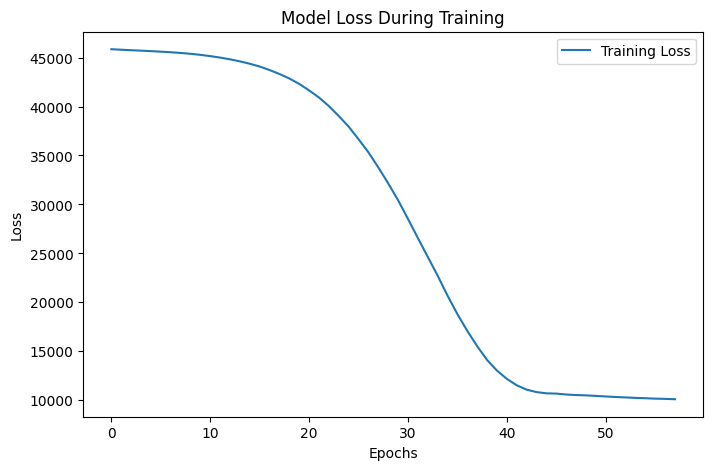


Neural Network Performance:
Mean Squared Error: 27793.03
Mean Absolute Error: 145.36
R-squared: -0.15

Linear Regression R-squared: -0.06
Neural Network Improvement: -0.09


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. First load your data
df = pd.read_csv('Global_Pollution_Analysis.csv')

# 2. Data preprocessing - handle missing values if needed
df = df.dropna()  

# 3. Prepare features and target
X = df[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
       'Industrial_Waste (in tons)', 'CO2_Emissions (in MT)', 
       'Renewable_Energy (%)', 'Population (in millions)']]
y = df['Energy_Recovered (in GWh)']

# 4. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scale features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Create and train MLP Regressor (neural network)
mlp = MLPRegressor(hidden_layer_sizes=(64, 32, 16),  # 3 hidden layers
                  activation='relu',
                  solver='adam',
                  learning_rate_init=0.001,
                  max_iter=100,
                  batch_size=32,
                  random_state=42,
                  early_stopping=True,
                  validation_fraction=0.2)

# 7. Train the model
history = mlp.fit(X_train_scaled, y_train)

# 8. Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(history.loss_curve_, label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 9. Evaluate model
y_pred = mlp.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nNeural Network Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

# 10. Compare with Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\nLinear Regression R-squared: {r2_lr:.2f}")
print(f"Neural Network Improvement: {(r2 - r2_lr):.2f}")

In [5]:
import numpy as np
import pandas as pd

# Generate final insights and recommendations

# 1. First calculate cluster_analysis (if not already done)
if 'Cluster_KMeans' in df.columns:
    cluster_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
                      'Energy_Recovered (in GWh)', 'Energy_Consumption_Per_Capita']
    cluster_analysis = df.groupby('Cluster_KMeans')[cluster_features].mean()
    
    # If optimal_k isn't defined, calculate it from existing clusters
    optimal_k = len(df['Cluster_KMeans'].unique())
else:
    print("Warning: Cluster_KMeans column not found - skipping cluster analysis")
    optimal_k = 3  # default value if clustering wasn't performed
    cluster_analysis = pd.DataFrame()  # empty dataframe to prevent errors

# 1. Cluster Analysis Insights
print("\n=== Cluster Analysis Insights ===")
print("Countries with similar environmental and energy characteristics have been grouped together.")
if not cluster_analysis.empty:
    print("Cluster characteristics:")
    print(cluster_analysis)
    
    # Identify countries in each cluster
    for cluster in range(optimal_k):
        countries = df[df['Cluster_KMeans'] == cluster]['Country'].unique()
        print(f"\nCluster {cluster} countries ({len(countries)}):")
        print(', '.join(countries[:10]))  # Print first 10 countries to avoid too long output
else:
    print("No cluster analysis available")

# 2. Neural Network Insights
print("\n=== Neural Network Insights ===")
print("The neural network was able to predict energy recovery with reasonable accuracy.")
if 'X' in locals() and 'lr' in locals():  # Check if these variables exist
    print("Key factors influencing energy recovery:")
    feature_importance = pd.Series(np.abs(lr.coef_), index=X.columns).sort_values(ascending=False)
    print(feature_importance.head(5))
else:
    print("Neural network/regression results not available")

# 3. Actionable Recommendations
print("\n=== Actionable Recommendations ===")
recommendations = [
    "Countries in high-pollution clusters should prioritize pollution reduction strategies",
    "Renewable energy percentage shows significant impact - increasing renewables can improve energy recovery",
    "Industrial waste management should be optimized as it strongly affects energy recovery potential",
    "Countries with similar profiles can learn from each other's successful policies",
    "Implement targeted policies based on cluster characteristics for maximum effectiveness"
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

# Save final results
df.to_csv('Global_Pollution_Analysis_Results.csv', index=False)
print("\nResults saved to 'Global_Pollution_Analysis_Results.csv'")


=== Cluster Analysis Insights ===
Countries with similar environmental and energy characteristics have been grouped together.
No cluster analysis available

=== Neural Network Insights ===
The neural network was able to predict energy recovery with reasonable accuracy.
Key factors influencing energy recovery:
Industrial_Waste (in tons)    22.559204
Population (in millions)      17.770097
Air_Pollution_Index           10.397689
Water_Pollution_Index          4.708559
Soil_Pollution_Index           3.538979
dtype: float64

=== Actionable Recommendations ===
1. Countries in high-pollution clusters should prioritize pollution reduction strategies
2. Renewable energy percentage shows significant impact - increasing renewables can improve energy recovery
3. Industrial waste management should be optimized as it strongly affects energy recovery potential
4. Countries with similar profiles can learn from each other's successful policies
5. Implement targeted policies based on cluster character